In [31]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, LeavePGroupsOut
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[2:55]].min()

def scale(x):
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    scaler.fit(x)# + [0]*52)
    return scaler, scaler.transform(x)

In [49]:
def best_neigh(x, y, df, pca_range, neigh_range):
    best = -inf
    best_n = (None, None)
    best_clf = (None, None)

    for n_comp in pca_range:
        for n_neigh in neigh_range:
            pca = PCA(n_components=n_comp)
            pca.fit(x)
            x2 = pca.transform(x)
            
            neigh = KNeighborsRegressor(n_neighbors=n_neigh)
            neigh.fit(x2, y)
            
            groups = list(df.index.get_level_values(0))
            n_groups = int(len(set(groups)) / 3)
            
            cv=LeavePGroupsOut(n_groups=n_groups).split(x2, y, groups)
            score = cross_val_score(neigh, x2, y, cv=cv).mean() # cv=cv
            print(n_comp, '\t', n_neigh, '\t', round(score, 2))
            
            if score > best:
                best = score
                best_n = (n_comp, n_neigh)
                best_clf = (pca, neigh)
                
    print('--------------')
    print('PCA:\t', best_n[0])
    print('kNN:\t', best_n[1])
    print('Score:\t', best)
    return best_clf, x2

In [46]:
out_dir = '../papi_output/'
paths = [out_dir + p for p in ['t1.csv']]

dfs = [pd.read_csv(path, error_bad_lines=False) for path in paths]
df = pd.concat(dfs)
df = aggregate(df)

df = df.loc[df['time'] > 1]

for col in df.columns[:52]:
    df[col] = df[col].apply(lambda q: np.log(q) if q>0 else 0)

cols = sorted(list(df.columns.values))
df = df[cols]

x = df.iloc[:,:52].as_matrix()
scaler, x = scale(x)
y = df.iloc[:,52].as_matrix()

df.shape

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(463, 53)

In [50]:
(pca, neigh), x2 = best_neigh(x, y, df, range(2, 15, 3), range(6, 20, 4))

2 	 6 	 0.82
2 	 10 	 0.81
2 	 14 	 0.8


KeyboardInterrupt: 

In [54]:
pca = PCA(n_components=4)
pca.fit(x)
x2 = pca.transform(x)
pca.explained_variance_ratio_.sum()

0.867291282032615

In [74]:
svr = SVR(kernel='linear', C=1, epsilon=.1)
svr.fit(x2, y)
clf = svr

In [55]:
neigh = KNeighborsRegressor(n_neighbors=6)
neigh.fit(x2, y) 
clf = neigh

In [38]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x2, y)
clf = regr

In [56]:
groups = list(df.index.get_level_values(0))
n_groups = int(len(set(groups)) / 3)

cv=LeavePGroupsOut(n_groups=n_groups).split(x2, y, groups)
cvres = list(cv)
group_names = [groups[q[1][0]] for q in cvres]

scores = cross_val_score(clf, x2, y, cv=cvres)

print('\n'.join([str(round(s, 2))+'\t'+g for g, s in zip(group_names, scores)]))
scores.mean()

0.84	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.86	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.88	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.91	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.93	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.9	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.9	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.89	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.9	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.87	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.91	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.6	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.8	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.85	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.87	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.9	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.92	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.89	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.9	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.88	lore_1f71e097-

0.7739414325962812

In [16]:
def graph(clf, pca, x2):
    if pca.n_components != 2:
        print('PCA must be 2D')

    norm = matplotlib.colors.LogNorm(vmin=y.min(), vmax=y.max())
    fig, ax = plt.subplots()
    
    plt.title('Prediction after dimensionality reduction')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    x0 = x2[:,0]
    x1 = x2[:,1]

    # grid
    xmin = min(x0)
    xmax = max(x0)
    xstep = (xmax-xmin)/99.1

    ymin = min(x1)
    ymax = max(x1)
    ystep = (ymax-ymin)/99.1

    xrange = np.arange(xmin, xmax, xstep)
    yrange = np.arange(ymin, ymax, ystep)
    xx, yy = np.meshgrid(xrange, yrange)

    xrange_grid = np.arange(xmin-xstep/2, xmax+xstep/2, xstep)
    yrange_grid = np.arange(ymin-ystep/2, ymax+ystep/2, ystep)
    xx_grid, yy_grid = np.meshgrid(xrange_grid, yrange_grid)

    ypred = clf.predict(list(zip(xx.ravel(), yy.ravel())))
    ypred = [q if q>0 else y.min() for q in ypred]
    ypred = np.array(ypred).reshape(len(yrange_grid)-1, len(xrange_grid)-1)

    pcm = ax.pcolor(xx_grid, yy_grid, ypred, norm=norm)

    cbar = fig.colorbar(pcm, ax=ax, extend='max')
    cbar.set_label('Execution time (log scale)', rotation=270, va='top')

    # scatter
    ax.scatter(x2[:,0], x2[:,1], c=y, norm=norm, edgecolors='black', s=60)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

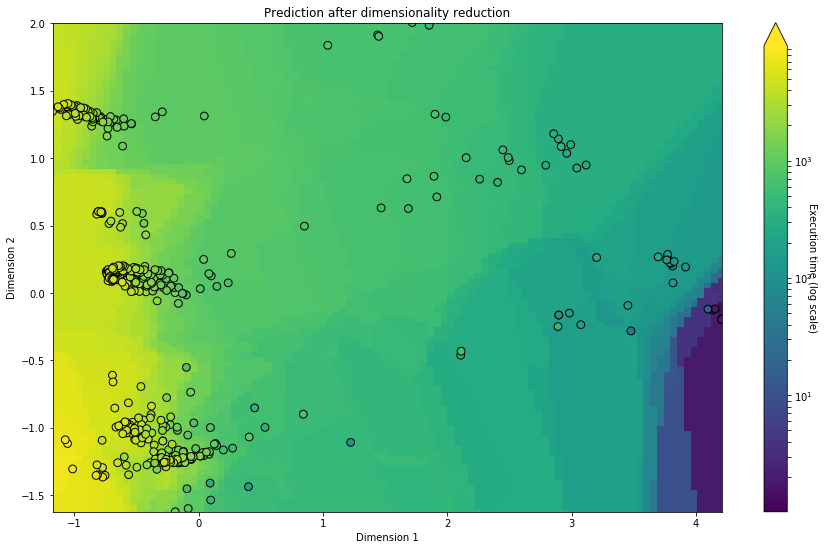

In [53]:
graph(clf, pca, x2)

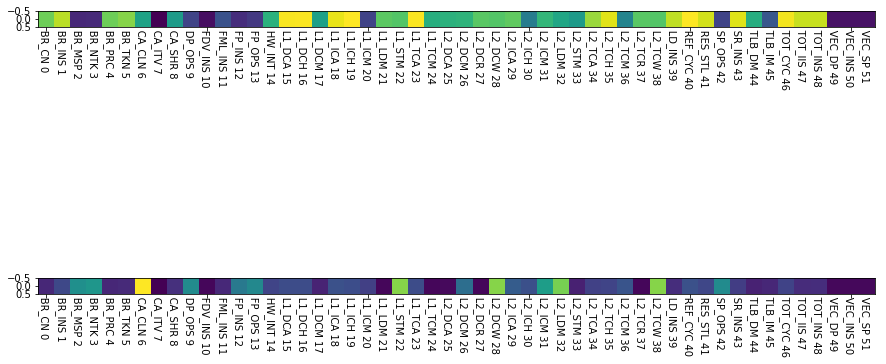

In [24]:
# just to visualize which of 52 PAPI output events are most significant (marked in yellow)

lab = df.columns[:52]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    for j, txt in enumerate(lab):
        ax.annotate('      '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    pcas = [abs(q) for q in pca.components_[i:i+1]]
    ax.imshow(pcas)
    ax.set_xticklabels([])
plt.show()

In [75]:
xtest = [4497449,7371,1328063,99,4448118,1328162,12325,20770,0,5452469,373413,5811940,973353,-714272,2042434,171,201090867,200906169,9991,9953,201080819,3756817690,3705109141,0,1505390728,198404403,199318100,0,883212989,2100347613,1953588754,1958086203,6785293,5811940,973353,1818994023,12747,1819001394,12846,5512011,3777087597,6840173,5824786,973353,0,0,0,0,0,0,0,2088825402]
ytrue = 1120
xtest = [np.log(q) if q>0 else 0 for q in xtest]
xtest = scaler.transform([xtest])
xtest = pca.transform(xtest)
print('pca: ', xtest)
clf.predict(xtest)

pca:  [[ 64.70654192  35.57659225]]


array([ 10.852])

In [225]:
xtest = df.iloc[:30,1:53].as_matrix()
scaler, xtest = scale(xtest)
ytest = df.iloc[:30,53].as_matrix()
xtest = pca.transform(xtest)
ypred = clf.predict(xtest)
for yp, yt in zip(ypred, ytest):
    print(int(yp), '\t', int(yt))

3522 	 1182
81 	 86
80410 	 90237
11 	 4
9 	 4
14682 	 10960
788 	 614
1770 	 2006
5842 	 2706
43 	 34
7 	 6
72213 	 25082
17229 	 10150
73 	 57
60747 	 42265
100 	 70
10047 	 1778
3584 	 1584
236 	 112
7510 	 4277
67 	 73
56 	 43
8394 	 4809
928 	 214
698 	 828
11925 	 4675
5011 	 2429
11 	 6
7217 	 5799
49952 	 49380


In [74]:
df

PAPI_L1_DCM  \
alg                                            run                                            
lore_071e0363-89a9-4aac-9f74-05b0f47c1098_444  -D PARAM_W=1264 -D PARAM_H=1264     5.736572   
                                               -D PARAM_W=1581 -D PARAM_H=1581     5.303305   
                                               -D PARAM_W=1897 -D PARAM_H=1897     5.690359   
                                               -D PARAM_W=2213 -D PARAM_H=2213     5.556828   
                                               -D PARAM_W=2529 -D PARAM_H=2529     5.602119   
                                               -D PARAM_W=2846 -D PARAM_H=2846     5.786897   
                                               -D PARAM_W=3162 -D PARAM_H=3162     5.739793   
lore_14053ed6-240b-44f7-aa83-09b557e539ee_550  -D PARAM_H=100000                  15.476755   
                                               -D PARAM_H=133333                  15.476755   
                                               -D PARAM_H=166666                  15.476755   
                                               -D PARAM_H=200000                  15.476755   
                                               -D PARAM_H=233333                  15.476755   
                                               -D PARAM_H=266666                  15.476755   
                                               -D PARAM_H=300000                  15.476755   
                                               -D PARAM_H=33333                   15.476755   
                                               -D PARAM_H=333333                  15.476755   
                                               -D PARAM_H=66666                   15.476755   
lore_1e5201b1-b9b4-442e-960e-94b11bbc01bc_119  -D PARAM_N2=150000                 10.542627   
                                               -D PARAM_N2=200000                 10.827032   
                                               -D PARAM_N2=250000                 10.370330   
                                               -D PARAM_N2=300000                 11.041032   
                                               -D PARAM_N2=350000                 10.797410   
                                               -D PARAM_N2=400000                 11.518172   
                                               -D PARAM_N2=450000                 11.635541   
                                               -D PARAM_N2=500000                 11.740531   
lore_1e5201b1-b9b4-442e-960e-94b11bbc01bc_1336 -D PARAM_N=1000000                  9.141419   
                                               -D PARAM_N=400000                   9.457513   
                                               -D PARAM_N=500000                   8.997395   
                                               -D PARAM_N=600000                   9.565214   
                                               -D PARAM_N=700000                   7.762171   
...                                                                                     ...   
lore_facfe86b-107f-4487-8ae3-a453312a0b9f_494  -D PARAM_ETINR=100000              10.629005   
                                               -D PARAM_ETINR=1000000             10.122744   
                                               -D PARAM_ETINR=200000              10.215557   
                                               -D PARAM_ETINR=300000               5.225747   
                                               -D PARAM_ETINR=400000              10.506190   
                                               -D PARAM_ETINR=500000              11.050318   
                                               -D PARAM_ETINR=600000               7.333023   
                                               -D PARAM_ETINR=700000              11.049524   
                                               -D PARAM_ETINR=800000              10.914743   
                                               -D PARAM_ETINR=900000               9.64969